In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0]* block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [8]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8* len(words))
n2 = int(0.9* len(words))

Xt, Yt = build_dataset(words[:n1])
Xv, Yv = build_dataset(words[n1:n2])
Xe, Ye = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
C = torch.randn((27,2))

In [10]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [11]:
wt = torch.randn((6,100))
b = torch.randn(100)

In [12]:
wt.shape,b.shape

(torch.Size([6, 100]), torch.Size([100]))

In [13]:
hidden = torch.tanh(emb.view(-1,6)@wt + b)

In [14]:
hidden.shape

torch.Size([228146, 100])

In [15]:
w2 = torch.randn((100,27))
b2 = torch.randn(27)

In [16]:
logits = hidden @w2 + b2

In [17]:
logits.shape

torch.Size([228146, 27])

In [18]:
counts = logits.exp()

In [19]:
prob = counts / counts.sum(1,keepdims = True)

In [20]:
prob.shape

torch.Size([228146, 27])

In [21]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator = g)
w1 = torch.randn((30,200), generator = g)
b1 = torch.randn(200, generator = g)
w2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C,w1,b1,w2,b2]

In [22]:
sum(p.nelement() for p in parameters)

11897

In [23]:
for p in parameters:
    p.requires_grad = True

In [24]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [25]:
lri = []
lossi = []
stepi = []

In [26]:
for i in range(50000):
    # builds minibatch
    ix = torch.randint(0, Xt.shape[0],(32,))
    
    # forward pass
    emb = C[Xt[ix]]
    h = torch.tanh(emb.view(-1,30)@w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Yt[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i<10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())
    

/home/dsladmin/anaconda3/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


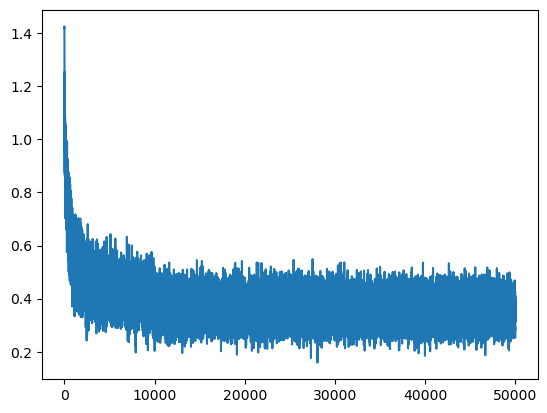

In [27]:
plt.plot(stepi, lossi)

In [28]:
emb = C[Xt]
h = torch.tanh(emb.view(-1,30)@w1 + b1)
logits = h@ w2 + b2
loss = F.cross_entropy(logits, Yt)
loss

tensor(2.2936, grad_fn=<NllLossBackward0>)

In [29]:
emb = C[Xv]
h = torch.tanh(emb.view(-1,30)@w1 + b1)
logits = h@w2+b2
loss = F.cross_entropy(logits, Yv)
loss

tensor(2.3099, grad_fn=<NllLossBackward0>)

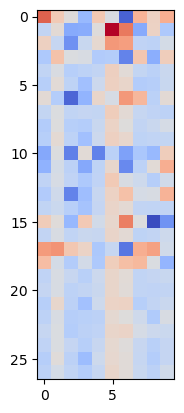

In [30]:
plt.imshow(C.detach().numpy(), cmap = 'coolwarm',interpolation='nearest')
#plt.colorbar()  # Add color bar
plt.show()

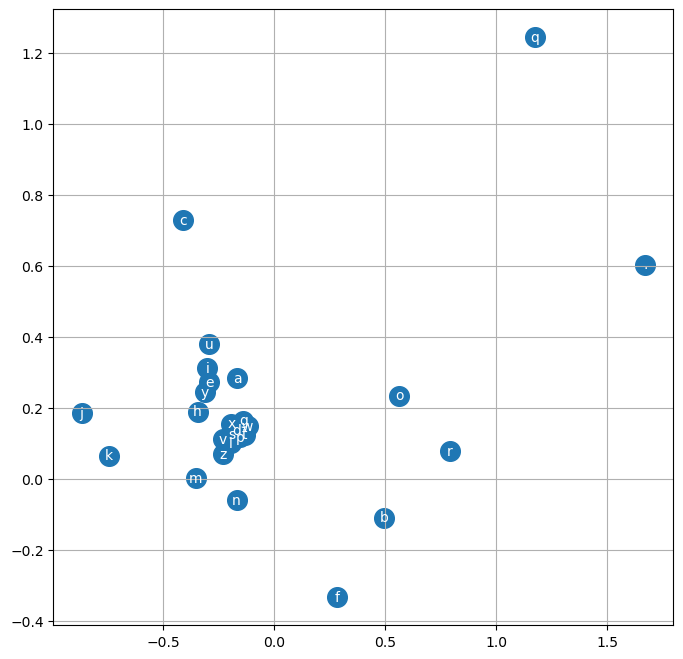

In [31]:
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = 'center', va = 'center', color='white')
plt.grid('minor')

In [32]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [35]:
g = torch.Generator().manual_seed(2147483647 + 11)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim =1)
        ix = torch.multinomial(probs,num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

reenai
rahaz
sharawcenzyan
nakeri
ziyah
rox
beel
jax
meev
hamnen
khiaanisneyla
ewon
jaquane
jedties
lop
kalexs
tha
mar
beshonsanbitlarijaydon
berahdlissa
